In [1]:
# read data: 30 ICs 
import nipype.interfaces.io as nio
import os
PD_ICA_file='/templateflow/PD_ICAs';
ICs_list=list(range(30))
ICs_list=["{:0>4d}".format(x) for x in ICs_list]
# file import
ds_ic = nio.DataGrabber(infields=['IC_id'])
ds_ic.inputs.base_directory = PD_ICA_file # database
ds_ic.inputs.template = 'melodic_IC_%4s.nii.gz' # from cwd
ds_ic.inputs.sort_filelist = True
ds_ic.inputs.IC_id = ICs_list
res_ic = ds_ic.run()
ic_list=res_ic.outputs.outfiles
# read local ic
PD_ICA_local_file='/output/PD_ICA/ICA_local/stats';
ICs_local_list=[x+1 for x in list(range(19))]
#ICs_local_list=["{:0>4d}".format(x) for x in ICs_local_list]
# file import
ds_local_ic = nio.DataGrabber(infields=['IC_id'])
ds_local_ic.inputs.base_directory = PD_ICA_local_file # database
ds_local_ic.inputs.template = 'thresh_zstat%s.nii.gz' # from cwd
ds_local_ic.inputs.sort_filelist = True
ds_local_ic.inputs.IC_id = ICs_local_list
res_local_ic = ds_local_ic.run()
ic_local_list=res_local_ic.outputs.outfiles
#print(ic_local_list)
# read data: 3 study groups by sub_list 
GROUPS=['PD','ET','NC']
OUT_DIR='/output/PD_ICA/'
SUB_LIST=[]; AGE_LIST=[]; JCOB_LIST=[];
print('Local data: ')
for group_name in GROUPS:
    current_group=group_name
    current_sub_list_file = '/codes/devel/PD_Marker/'+current_group+'_info_ICA.list'
    # create dir for output
    current_OUT_DIR=OUT_DIR+current_group+'/'
    if not os.path.exists(current_OUT_DIR):
        os.makedirs(current_OUT_DIR)
    #read sub list
    with open(current_sub_list_file, 'r') as f_sub:
        sub_list_raw= f_sub.readlines()
    sub_list = [x[0:-1].split('\t')[0] for x in sub_list_raw] # remove 
    age_list = [int(x[0:-1].split('\t')[1]) for x in sub_list_raw]
    SUB_LIST.append(sub_list);  AGE_LIST.append(age_list);
    N_sub=len(sub_list)
    print(group_name, ': ', N_sub)
    # grab group Jacobians
    ds_jacobian = nio.DataGrabber(infields=['sub_id'])
    ds_jacobian.inputs.base_directory = current_OUT_DIR # database
    ds_jacobian.inputs.template = '%s_desc-preproc_T1w_space-MNI2009c_Warp_Jacobian.nii.gz' # from cwd
    ds_jacobian.inputs.sort_filelist = True
    ds_jacobian.inputs.sub_id = sub_list
    res_jacobian = ds_jacobian.run()
    jacobian_list=res_jacobian.outputs.outfiles
    JCOB_LIST.append(jacobian_list)
pd_sub_list = SUB_LIST[0]; et_sub_list = SUB_LIST[1]; nc_sub_list = SUB_LIST[2]; 
pd_age_list = AGE_LIST[0]; et_age_list = AGE_LIST[1]; nc_age_list = AGE_LIST[2];
pd_jaco_list=JCOB_LIST[0]; et_jaco_list=JCOB_LIST[1]; nc_jaco_list=JCOB_LIST[2];
# read all the AD-subjects
import pandas as pd
sub_list_file = '/output/PPMI_DBM_AD/subject_IDs.csv'
ad_sub_list_df=pd.read_csv(sub_list_file, sep=',', header=0, index_col=0)
ad_sub_label= ['PD' if x==1 else 'NC' for x in list(ad_sub_list_df['PD'])]
N_ad_sub=len(ad_sub_label); N_ad_PD=sum(list(ad_sub_list_df['PD'])); N_ad_NC=N_ad_sub-N_ad_PD;
ad_sub_list = [str(x) for x in list(range(N_ad_sub))]
ad_jacobian_dir='/output/PPMI_DBM_AD/sub_dbm/'
ad_jacobian = nio.DataGrabber(infields=['sub_id'])
ad_jacobian.inputs.base_directory = ad_jacobian_dir # database
ad_jacobian.inputs.template = 'sub-%s_dbm.nii.gz' # from cwd
ad_jacobian.inputs.sort_filelist = True
ad_jacobian.inputs.sub_id = ad_sub_list
res_ad_jacobian = ad_jacobian.run()
ad_jacobian_list=res_ad_jacobian.outputs.outfiles
print('AD data: \nPD : ', N_ad_PD, '\nNC : ', N_ad_NC)

201002-03:16:59,358 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0
Local data: 
PD :  40
ET :  29
NC :  33
AD data: 
PD :  232 
NC :  117


In [2]:
# read all group Jacobian data, and (all IC)*(all IMG) functions
import time
import nibabel as nib
def grab_groupXICA(IC_list, img_list, sub_list, sv_path):
    import nibabel as nib
    from nilearn.image import resample_to_img
    from nilearn.image import math_img
    from scipy import stats
    import numpy as np
    x_list=[]; y_list=[];
    N_sub=len(img_list)
    N_IC=len(IC_list)
    y_list=[]
    #print('gourp++')
    for i_ic in range(N_IC):
        print('ic: ', str(i_ic))
        ic_img=nib.load(IC_list[i_ic])
        x_list=[]
        for i_sub in range(N_sub):
            # cal img * img
            sub_img=nib.load(img_list[i_sub])
            if sub_img.shape[0] > ic_img.shape[0]:
                sub_img_re = resample_to_img(sub_img, ic_img)
                ic_img_re  = ic_img;
            elif sub_img.shape[0] == ic_img.shape[0]:
                sub_img_re = sub_img;
                ic_img_re  = ic_img;
            else:
                ic_img_re  = resample_to_img(ic_img, sub_img)
                sub_img_re = sub_img;
            sub_img_x  = math_img("img1 * img2", img1=ic_img_re, img2=sub_img_re)
            nib.save(sub_img_x, sv_path+sub_list[i_sub]+'-xIC'+str(i_ic)+'.nii.gz')
            ic_data = ic_img_re.get_fdata().reshape(-1);
            nz_pos=np.flatnonzero(ic_data)
            ic_val=list(ic_data.ravel()[nz_pos])
            sub_dat = sub_img_re.get_fdata().reshape(-1);
            sub_val=list(stats.zscore(sub_dat.ravel()[nz_pos]))
            x_list.append(np.corrcoef(sub_val, ic_val)[0,1])
        y_list.append(x_list)
    return y_list

In [5]:
## ET-IC x AD-IMG
# read ET ic
ET_ICA_file='/output/PD_ICA/ICA_local_et+nc/stats';
N_et_ic=41
ET_IC_list=[x+1 for x in list(range(N_et_ic))]
#ICs_local_list=["{:0>4d}".format(x) for x in ICs_local_list]
# file import
ds_et_ic = nio.DataGrabber(infields=['IC_id'])
ds_et_ic.inputs.base_directory = ET_ICA_file # database
ds_et_ic.inputs.template = 'thresh_zstat%s.nii.gz' # from cwd
ds_et_ic.inputs.sort_filelist = True
ds_et_ic.inputs.IC_id = ET_IC_list
res_et_ic = ds_et_ic.run()
ic_et_list=res_et_ic.outputs.outfiles

import os
N_ad_ic=len(ic_list); N_ab_ic=len(ic_local_list);
N_ab_pd=len(pd_sub_list); N_ab_et=len(et_sub_list); N_ab_nc=len(nc_sub_list);
N_ad_pd= N_ad_PD; N_ad_nc=N_ad_NC;
# AB and AD subjust data preparation
ET_AB_OUT_DIR = '/output/ET-IC_AB-IMG/'; ET_AD_OUT_DIR = '/output/ET-IC_AD-IMG/'

## et-IC x AD-IMG
t0=time.time()
print('PPMI dataset: ', N_ad_sub)
et_ad_jaco_corr=grab_groupXICA(ic_et_list, ad_jacobian_list, ad_sub_list, ET_AD_OUT_DIR)
print('ET-IC x PPMI group takes: ', str(time.time()-t0))
import numpy as np
import pandas as pd
ab_sub_y      = [1]*N_AB_PD+[0]*N_AB_NC+[-1]*N_AB_ET
et_ad_corr=np.array(et_ad_jaco_corr).T
et_ic_names=['ic'+str(x) for x in list(range(N_et_ic))]
et_ad_group_corr=pd.DataFrame(et_ad_corr, columns=et_ic_names)
et_ad_group_corr['label']=ad_sub_label
et_ad_group_corr['PD']=list(ad_sub_list_df['PD'])
et_ad_group_corr['ID']=ad_sub_list_df.index
et_ad_group_corr.to_csv('et-ad_mean-corr.csv')

PPMI dataset:  349
ic:  0
ic:  1
ic:  2
ic:  3
ic:  4
ic:  5
ic:  6
ic:  7
ic:  8
ic:  9
ic:  10
ic:  11
ic:  12
ic:  13
ic:  14
ic:  15
ic:  16
ic:  17
ic:  18
ic:  19
ic:  20
ic:  21
ic:  22
ic:  23
ic:  24
ic:  25
ic:  26
ic:  27
ic:  28
ic:  29
ic:  30
ic:  31
ic:  32
ic:  33


KeyboardInterrupt: 

['/output/ants_test/TemplateBuildingExample-master/BrainSlices/OASIS-TRT-20-10Slice121.nii.gz', '/output/ants_test/TemplateBuildingExample-master/BrainSlices/OASIS-TRT-20-11Slice121.nii.gz', '/output/ants_test/TemplateBuildingExample-master/BrainSlices/OASIS-TRT-20-12Slice121.nii.gz', '/output/ants_test/TemplateBuildingExample-master/BrainSlices/OASIS-TRT-20-13Slice121.nii.gz', '/output/ants_test/TemplateBuildingExample-master/BrainSlices/OASIS-TRT-20-14Slice121.nii.gz', '/output/ants_test/TemplateBuildingExample-master/BrainSlices/OASIS-TRT-20-15Slice121.nii.gz', '/output/ants_test/TemplateBuildingExample-master/BrainSlices/OASIS-TRT-20-16Slice121.nii.gz', '/output/ants_test/TemplateBuildingExample-master/BrainSlices/OASIS-TRT-20-17Slice121.nii.gz', '/output/ants_test/TemplateBuildingExample-master/BrainSlices/OASIS-TRT-20-18Slice121.nii.gz', '/output/ants_test/TemplateBuildingExample-master/BrainSlices/OASIS-TRT-20-19Slice121.nii.gz', '/output/ants_test/TemplateBuildingExample-master

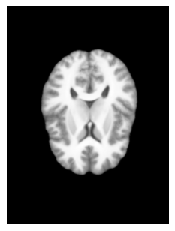

In [7]:
import ants
import os
import glob

dataDirectory = '/output/ants_test/TemplateBuildingExample-master/BrainSlices/'
populationFiles = glob.glob( dataDirectory + "OASIS*Slice121.nii.gz" )
print(populationFiles)
population = list()
for i in range( len( populationFiles ) ):
  population.append( ants.image_read( populationFiles[i], dimension = 2 ) )

btp = ants.build_template( initialTemplate = None,
  image_list = population,
  iterations = 4,
  gradient_step = 0.2,
  verbose = True,
  syn_metric = 'CC',
  reg_iterations = ( 100, 70, 50, 0 ) )

ants.plot( btp )